In [1]:
import sys, os
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.stats import scott_bin_width
import h5py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gwb
from gwb.data import TGASData

In [3]:
style.use('notebook.mplstyle')

In [4]:
tgas = TGASData('../data/stacked_tgas.fits')

# Results

In [5]:
pairidx_rand = fits.getdata('../output/random/snr8_random200000.fits')
with h5py.File("../output/random/snr8_random200000_vscatter0-lratio.h5") as f:
    lnH1_rand = f['lnH1'].value
    lnH2_rand = f['lnH2'].value
    llr_rand = lnH1_rand - lnH2_rand
    
# throw out nans
bad = isnan(llr_rand)
pairidx_rand = pairidx_rand[~bad]
lnH1_rand = lnH1_rand[~bad]
lnH2_rand = lnH2_rand[~bad]
llr_rand = llr_rand[~bad]

# pairidx_rand_sn32 = fits.getdata('../output/random/snr32_random100000.fits')
# with h5py.File("../output/random/snr32_random100000_vscatter0-lratio.h5") as f:
#     lnH1_rand_sn32 = f['lnH1'].value
#     lnH2_rand_sn32 = f['lnH2'].value
#     llr_rand_sn32 = lnH1_rand_sn32 - lnH2_rand_sn32
    
# throw out nans
# bad = isnan(llr_rand_sn32)
# pairidx_rand_sn32 = pairidx_rand_sn32[~bad]
# lnH1_rand_sn32 = lnH1_rand_sn32[~bad]
# lnH2_rand_sn32 = lnH2_rand_sn32[~bad]
# llr_rand_sn32 = llr_rand_sn32[~bad]

pairidx = fits.getdata('../output/21081/snr8_n128_dv10.fits')
with h5py.File("../output/21081/snr8_n128_dv10_vscatter0-lratio.h5") as f:
    lnH1 = f['lnH1'].value
    lnH2 = f['lnH2'].value
    llr = lnH1 - lnH2

In [6]:
tgas1_rand = tgas[pairidx_rand['star1']]
tgas2_rand = tgas[pairidx_rand['star2']]
min_snr_rand = np.min(np.vstack((tgas1_rand.parallax_snr, tgas2_rand.parallax_snr)), axis=0)

tgas1 = tgas[pairidx['star1']]
tgas2 = tgas[pairidx['star2']]
min_snr = np.min(np.vstack((tgas1.parallax_snr, tgas2.parallax_snr)), axis=0)
dvtan = np.sqrt(np.sum((tgas1.get_vtan() - tgas2.get_vtan())**2, axis=1))
vtan1 = norm(tgas1.get_vtan(), axis=1)
c1 = tgas1.get_coord()
c2 = tgas2.get_coord()
sep = c1.separation_3d(c2)

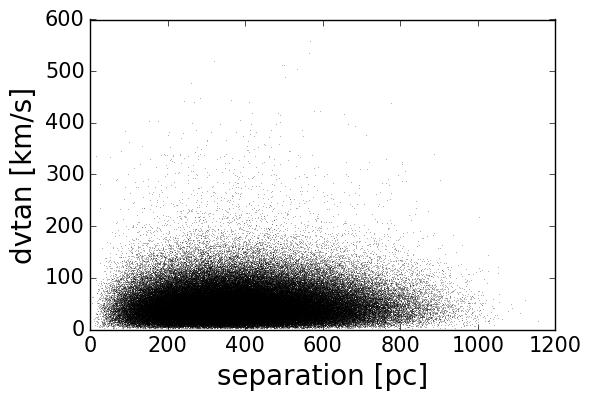

In [8]:
plot(pairidx_rand['sep'], pairidx_rand['delta_v'], 'k,', alpha=.3)
# xscale('log')
# yscale('log')
xlabel('separation [pc]')
ylabel('dvtan [km/s]')

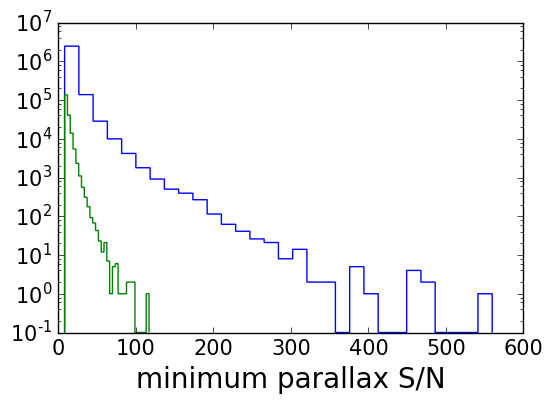

In [9]:
_ = hist(min_snr, 30, log=True, histtype='step')
_ = hist(min_snr_rand, 30, log=True, histtype='step')
xlabel('minimum parallax S/N')

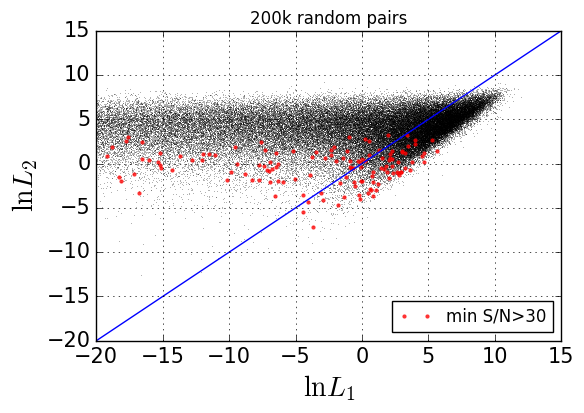

In [23]:
plot(lnH1_rand, lnH2_rand, 'k,', alpha=.3)
plot(lnH1_rand[min_snr_rand>30], lnH2_rand[min_snr_rand>30], 'r.', alpha=.8,
     label='min S/N>30')
# xscale('symlog')
# yscale('symlog')
xlim(-20,15)
ylim(-20,15)
plot(linspace(-50,20), linspace(-50,20))
grid()
xlabel(r'$\ln L_1$')
ylabel(r'$\ln L_2$')
legend(loc='lower right')
title('200k random pairs')


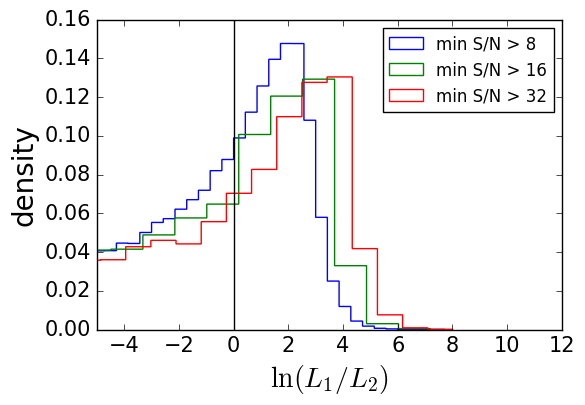

In [45]:
for cut in [8, 16,]:
    prune = llr_rand>-15
    cond = prune & (min_snr_rand>cut)
    bins = scott_bin_width(llr_rand[cond], return_bins=True)[1]
    hist(llr_rand[cond], bins, normed=True, histtype='step',
         label='min S/N > %i' % (cut))

prune = llr_rand_sn32>-15
bins = scott_bin_width(llr_rand_sn32[prune], return_bins=True)[1]
hist(llr_rand_sn32[prune], bins, normed=True, histtype='step',
         label='min S/N > 32')

legend(loc='upper right')
xlim(-5,12)
xlabel(r'$\ln (L_1/L_2)$')
ylabel('density')
axvline(0., c='k')

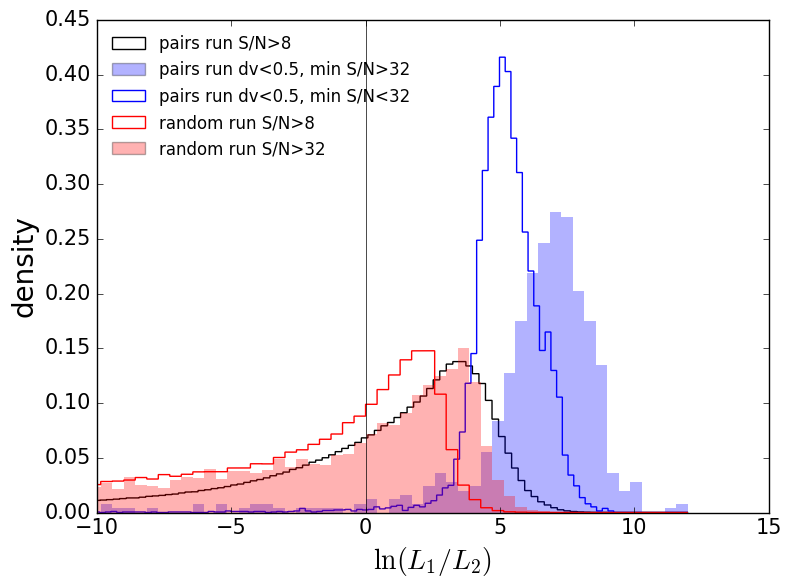

In [59]:
figure(figsize=(8, 6))
hist(llr, bins=np.linspace(-50,12,256), color='k', histtype='step',
     normed=True, label='pairs run S/N>8')
hist(llr[(min_snr>32) & (dvtan.value<.5)], alpha=.3,
     bins=np.linspace(-15,12,64), color='b',
     normed=True, label='pairs run dv<0.5, min S/N>32')
hist(llr[(min_snr<32) & (dvtan.value<.5)],
     bins=np.linspace(-15,12,128), histtype='step', color='b',
     normed=True, label='pairs run dv<0.5, min S/N<32')
plt.xlabel(r'$\ln (L_1/L_2)$')
xlim(-10,15)

_ = hist(llr_rand, bins=linspace(-15,12,64), color='r', histtype='step', normed=True,
         label='random run S/N>8')
_ = hist(llr_rand_sn32, bins=linspace(-15,12,64), color='r', normed=True, alpha=.3,
         label='random run S/N>32')
legend(loc='upper left', frameon=False)
ylim(0,0.45)
ylabel('density')
axvline(0., c='k', lw=.5)
tight_layout()
savefig('likelihoodratios.png')

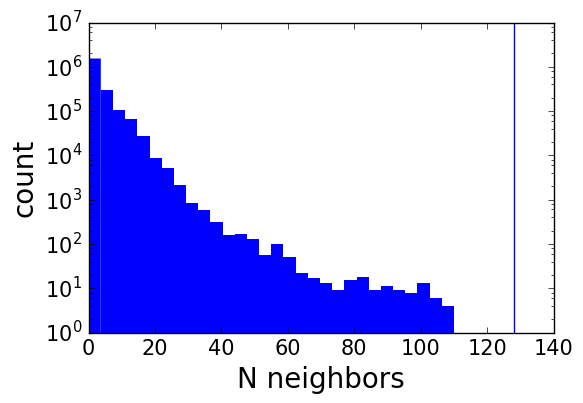

In [13]:
_ = plt.hist(np.sort(np.bincount(pair_idx[:,0])), 30, log=True)
plt.xlabel('N neighbors')
plt.ylabel('count')
plt.axvline(128.)

# Likelihood ratio vs params

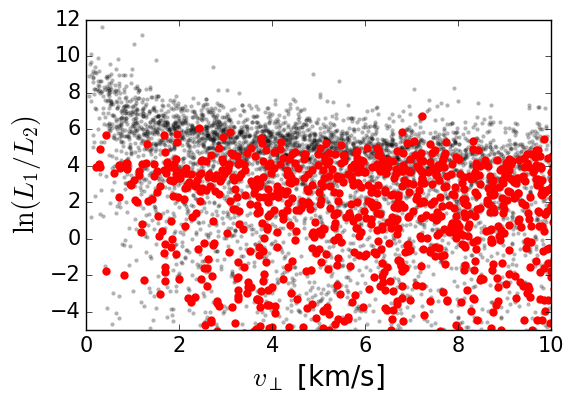

In [92]:

plot(dvtan[min_snr>64], llr[min_snr>64], 'k.', alpha=.3)
plot(pairidx_rand_sn32['delta_v'], llr_rand_sn32, 'ro')
ylim(-5,12)
# yscale('log')
xlim(0,10)
xlabel(r'$v_\perp$ [km/s]')
ylabel('$\ln(L_1/L_2)$')

(8, 1000.0)

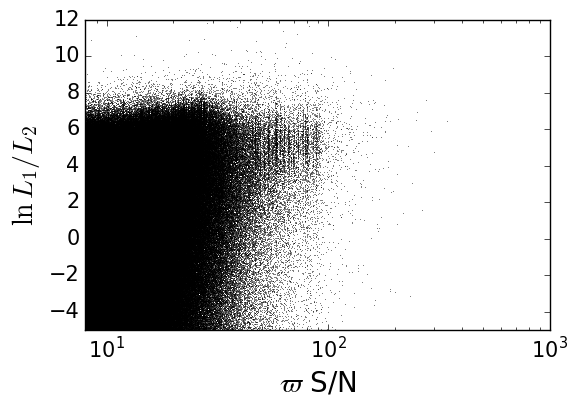

In [73]:
plot(min_snr, llr[::], 'k,', alpha=.5)
ylim(-5,12)
# yscale('log')
xlabel(r'$\varpi$ S/N')
ylabel('$\ln\,L_1/L_2$')
xscale('log')
xlim(8)
# ylim(2,8)

200000


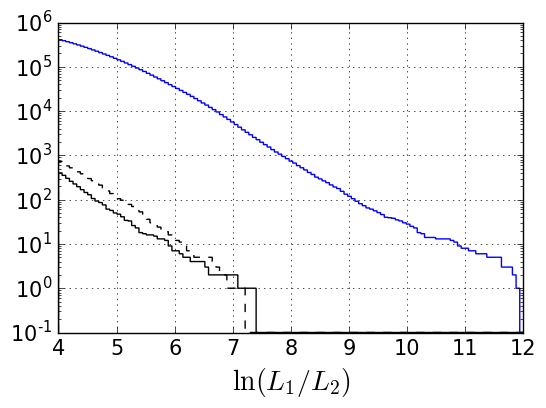

In [10]:
print(llr_rand.size)
_ = hist(llr, linspace(4,12,128), log=True, cumulative=-1, histtype='step',)
_ = hist(llr_rand, linspace(4,12,128), log=True, cumulative=-1,
         histtype='step', label='random', color='k')
_ = hist(llr_rand_sn32, linspace(4,12,128), log=True, cumulative=-1,
         histtype='step', label='random', color='k', ls='dashed')
grid()
xlabel(r'$\ln (L_1/L_2)$')

## Number of pairs

In [7]:
counts, bins = histogram(llr, arange(7., 13., .5),)
for binlow, cc in zip(bins[:-1], counts):
    print('> %4.1f %5i' % (binlow, cc))

>  7.0  3358
>  7.5  1144
>  8.0   418
>  8.5   169
>  9.0    60
>  9.5    23
> 10.0    15
> 10.5     5
> 11.0     3
> 11.5     5
> 12.0     0


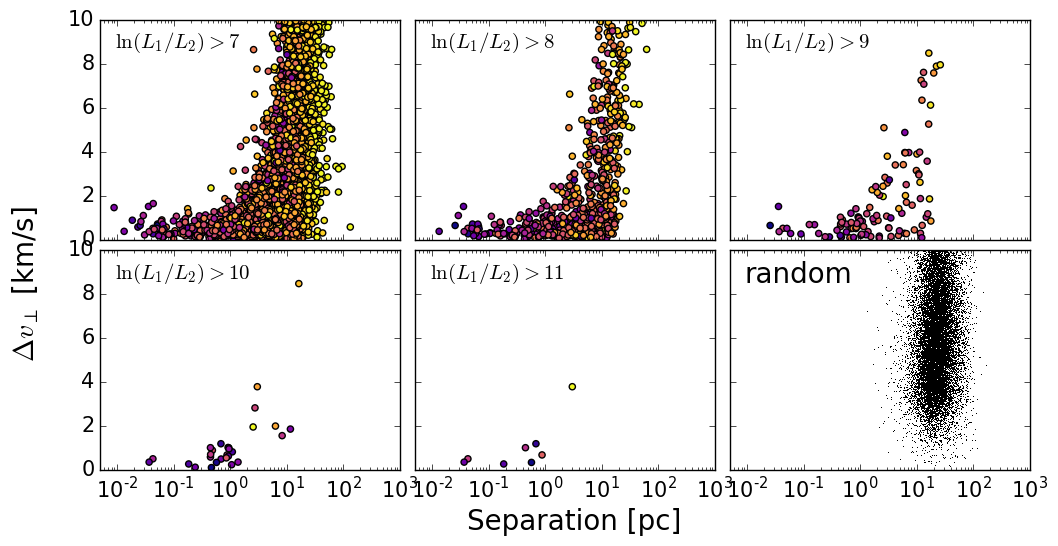

In [23]:
fig, ax = subplots(2, 3, figsize=(12,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05, bottom=0.15)
ax = ax.flatten()
for i, llrcut in enumerate([7, 8, 9, 10, 11]):
    sca(ax[i])
    cond = llr > llrcut
    scatter(sep[cond], dvtan[cond],
            c=min_snr[cond], edgecolors='k',
            norm=mpl.colors.LogNorm(), cmap='plasma_r')
    text(0.05, 0.95, r'$\ln(L_1/L_2) > %.0f$' % (llrcut), va='top', ha='left',
         transform=gca().transAxes, size=15)
ylim(0, 10)
xscale('log')
xlim(5e-3)

foo = (llr>3) & (llr<3.05)
ax[-1].plot(sep[foo], dvtan[foo], 'k,',)
ax[-1].text(0.05, 0.95, r'random', va='top', ha='left',
            transform=ax[-1].transAxes, size=20)
figtext(0.52,0.05, 'Separation [pc]', size=20, ha='center')
figtext(0.05,0.55, r'$\Delta v_\perp$ [km/s]', rotation='vertical', size=20)

In [ ]:
fig, ax = subplots(2, 3, figsize=(12,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = ax.flatten()
for i, llrcut in enumerate([7, 8, 9, 10, 11]):
    sca(ax[i])
    cond = llr > llrcut
    scatter(sep[cond], dvtan[cond], c=vtan1[cond], edgecolors='k', cmap='plasma_r')
ylim(0, 10)
xscale('log')
xlim(5e-3)

foo = (llr>3) & (llr<3.05)
ax[-1].plot(sep[foo], dvtan[foo], 'k,')

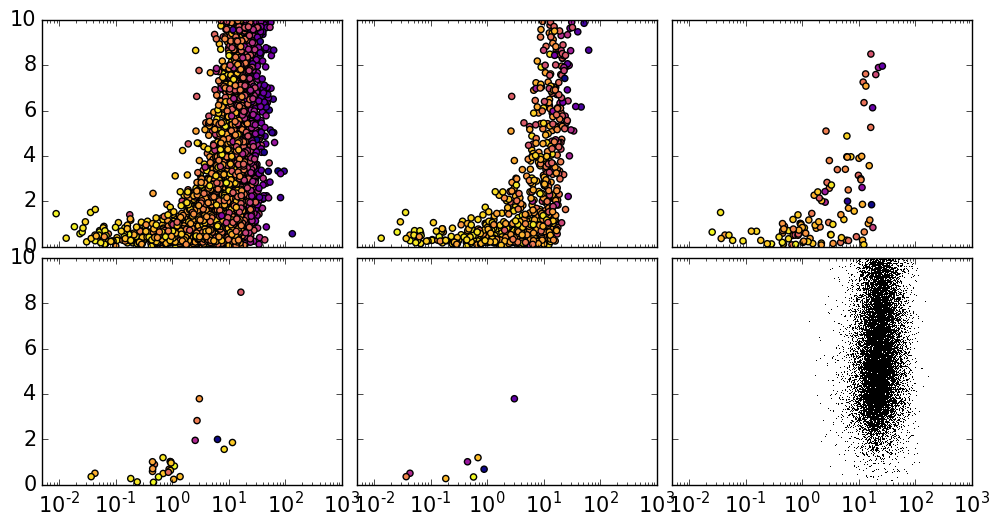

In [48]:
fig, ax = subplots(2, 3, figsize=(12,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = ax.flatten()
for i, llrcut in enumerate([7, 8, 9, 10, 11]):
    sca(ax[i])
    cond = llr > llrcut
    scatter(sep[cond], dvtan[cond], c=tgas1.get_distance()[cond], edgecolors='k', cmap='plasma_r')
ylim(0, 10)
xscale('log')
xlim(5e-3)

foo = (llr>3) & (llr<3.05)
ax[-1].plot(sep[foo], dvtan[foo], 'k,',)

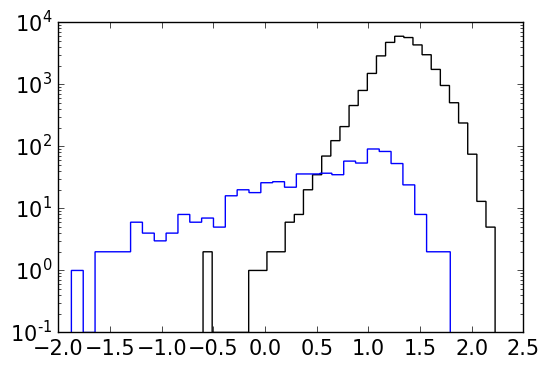

In [213]:
# bins = scott_bin_width(log10(sep[llr>8].value), return_bins=True)[1]
_ = hist(log10(sep[(llr>3) & (llr<3.1)].value), 32, log=True, histtype='step', color='k')
_ = hist(log10(sep[(llr>8)].value), 32, log=True, histtype='step')
# _ = hist(log10(pairidx_rand['sep']), 32, log=True)

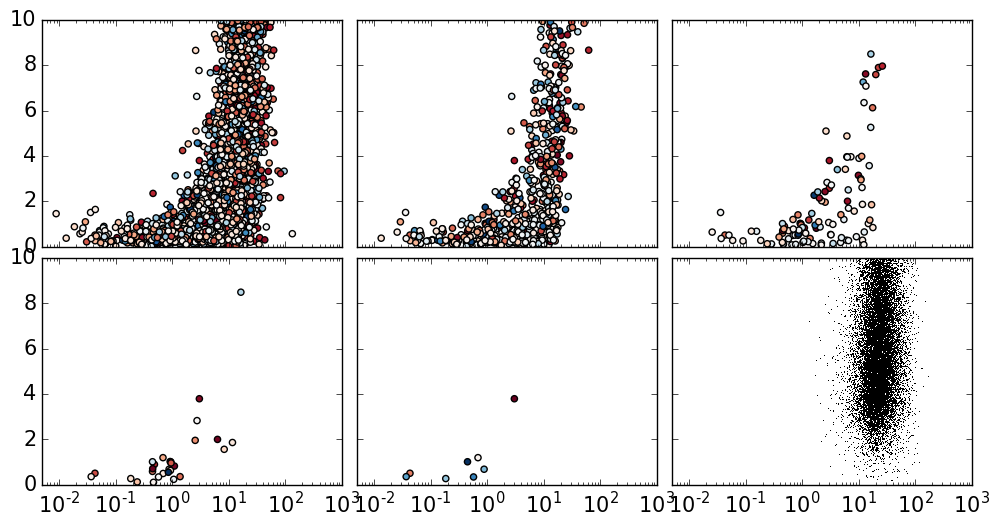

In [126]:
fig, ax = subplots(2, 3, figsize=(12,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = ax.flatten()
for i, llrcut in enumerate([7, 8, 9, 10, 11]):
    sca(ax[i])
    cond = llr > llrcut
    scatter(sep[cond], dvtan[cond], c=tgas1._data['parallax_pmdec_corr'][cond],
            edgecolors='k', cmap='RdBu')
ylim(0, 10)
xscale('log')
xlim(5e-3)

foo = (llr>3) & (llr<3.05)
ax[-1].plot(sep[foo], dvtan[foo], 'k,',)

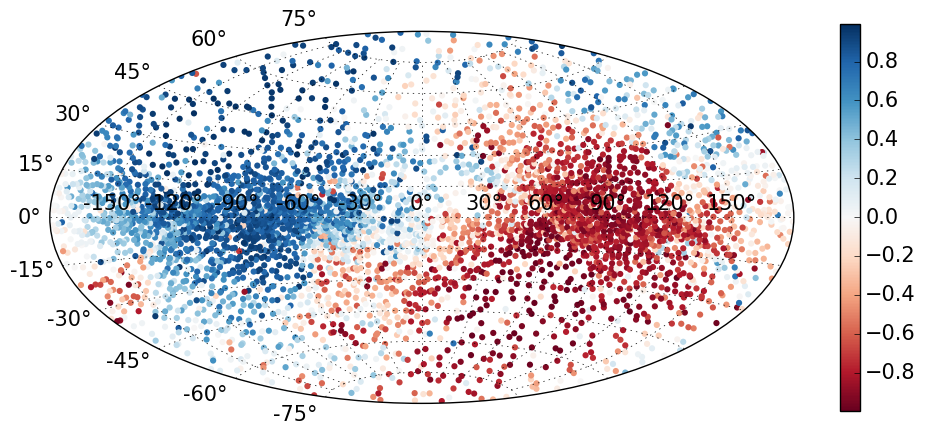

In [10]:
foo = (llr>8)
figure(figsize=(12,5))
axes(projection='aitoff')
grid()

tgasl = deg2rad(tgas.l[::500])
tgasb = deg2rad(tgas.b[::500])
parallax_pmra_corr = tgas._data['parallax_pmra_corr'][::500]
parallax_pmdec_corr = tgas._data['parallax_pmdec_corr'][::500]
tgasl[tgasl>pi] -= 2*pi

scatter(tgasl, tgasb, c=parallax_pmra_corr, cmap='RdBu')

colorbar()
savefig('parallax_pmra_corr_galactic.png')

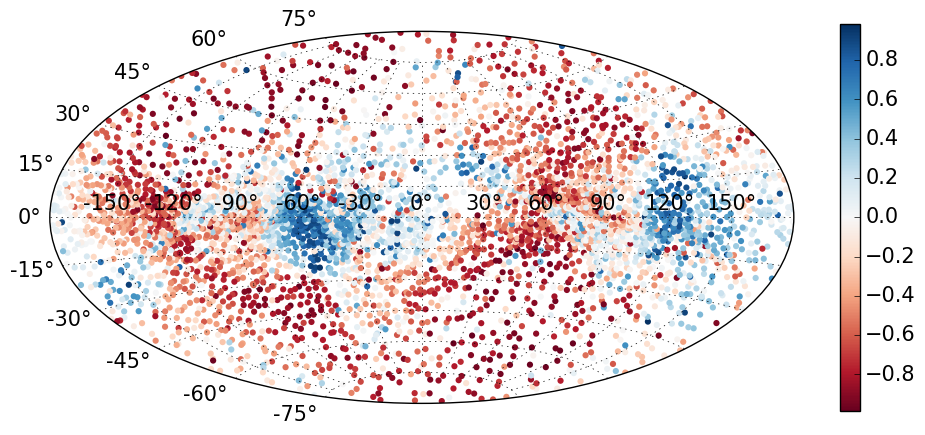

In [11]:
foo = (llr>8)
figure(figsize=(12,5))
axes(projection='aitoff')
grid()

tgasl = deg2rad(tgas.l[::500])
tgasb = deg2rad(tgas.b[::500])
parallax_pmra_corr = tgas._data['parallax_pmra_corr'][::500]
parallax_pmdec_corr = tgas._data['parallax_pmdec_corr'][::500]
tgasl[tgasl>pi] -= 2*pi

scatter(tgasl, tgasb, c=parallax_pmdec_corr, cmap='RdBu')

colorbar()
savefig('parallax_pmdec_corr_galactic.png')

In [149]:
vtan32 = tgas.get_vtan()[tgas.parallax_snr>32]

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [155]:
vtan32[:,0].value

array([-29.02094685, -29.63636503,  52.29921384, ...,  66.41986986,
         4.75920112,  32.33231566])

In [28]:
tgasra = tgas.ra.to(u.rad).value
tgasdec = tgas.dec.to(u.rad).value
tgasra[tgasra>pi] -= 2*pi
vtan = tgas.get_vtan()

tgasra1 = tgas1.ra.to(u.rad).value
tgasdec1 = tgas1.dec.to(u.rad).value
tgasra1[tgasra1>pi] -= 2*pi

/Users/semyeong/projects/gaia-wide-binaries/gwb/data.py:102: RuntimeWarning: invalid value encountered in sqrt
  tmp = self._data['parallax'] * (0.5 + 0.5*np.sqrt(1 - 16/snr**2))


In [13]:
l1,b1 = deg2rad(tgas1.l), deg2rad(tgas1.b)
l1[l1>pi] -= 2*pi
l2,b2 = deg2rad(tgas2.l), deg2rad(tgas2.b)
l2[l2>pi] -= 2*pi

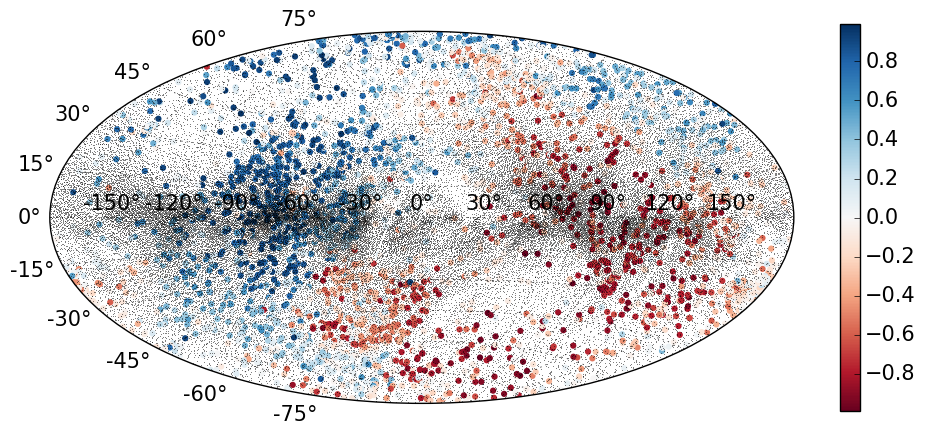

In [26]:
foo = (llr>7)
figure(figsize=(12,5))
axes(projection='aitoff')
grid()

tgasl = deg2rad(tgas.l[::30])
tgasb = deg2rad(tgas.b[::30])
tgasl[tgasl>pi] -= 2*pi

plot(tgasl, tgasb, 'k,', alpha=.5)

#     scatter(l1[foo], b1[foo], c=dvtan[foo], cmap=cmap)
#     scatter(l2[foo], b2[foo], c=dvtan[foo], cmap=cmap)


scatter(l1[foo], b1[foo], c=tgas1._data['parallax_pmra_corr'][foo], cmap='RdBu')
colorbar()
savefig('pairs_llr7_vtan1.png')

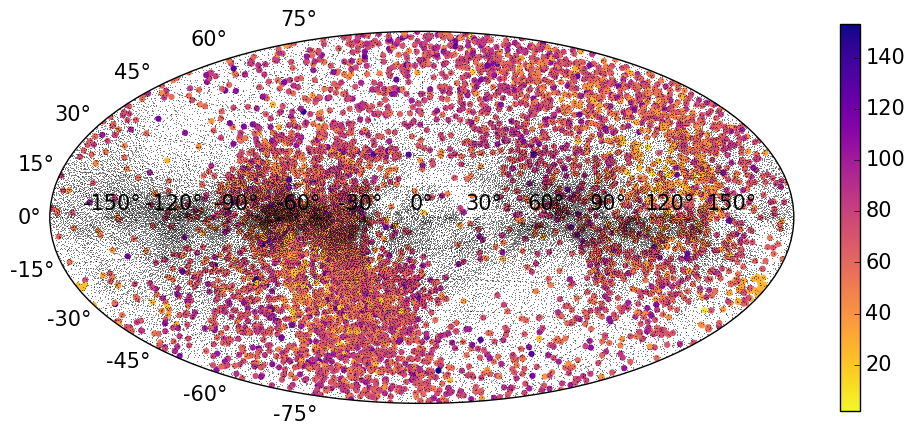

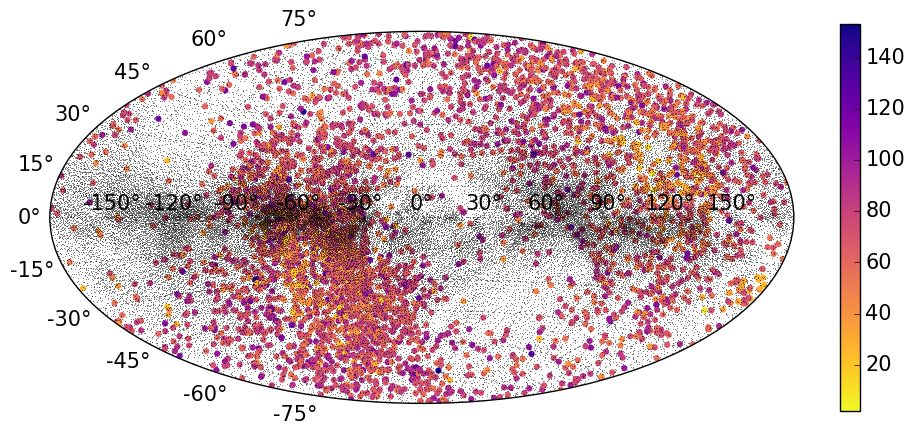

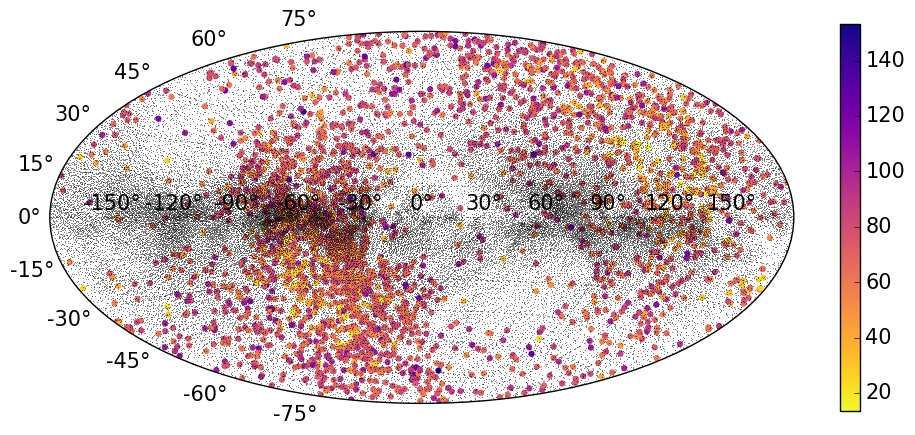

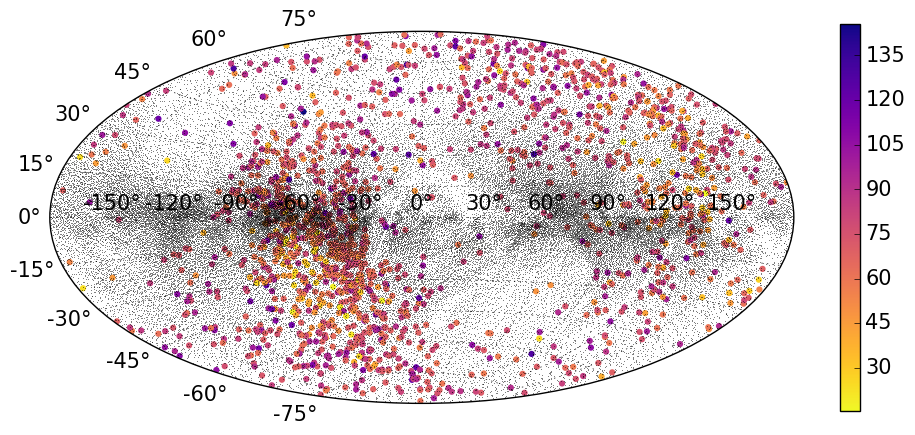

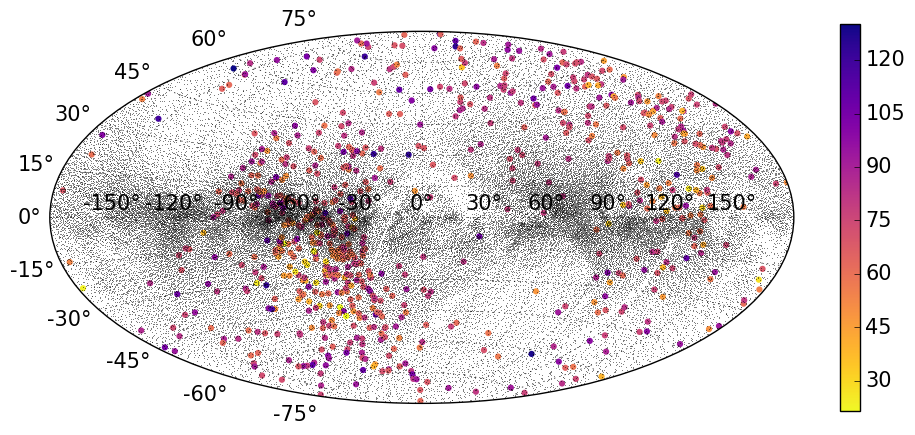

In [185]:
for dvcut in [5, 6, 7, 8, 9]:
    foo = (llr>6) & (dvtan.value>dvcut)
    figure(figsize=(12,5))
    axes(projection='aitoff')
    grid()

    tgasl = deg2rad(tgas.l[::30])
    tgasb = deg2rad(tgas.b[::30])
    tgasl[tgasl>pi] -= 2*pi

    plot(tgasl, tgasb, 'k,', alpha=.5)

#     scatter(l1[foo], b1[foo], c=dvtan[foo], cmap=cmap)
#     scatter(l2[foo], b2[foo], c=dvtan[foo], cmap=cmap)


    scatter(l1[foo], b1[foo], c=vtan1[foo], cmap=cmap)
    colorbar()

In [ ]:
tgasra = tgas.ra[::50].to(u.rad).value
tgasdec = tgas.dec[::50].to(u.rad).value
tgasra[tgasra>pi] -= 2*pi


In [63]:
sep_sky = c1.separation(c2)  # takes long

In [24]:
cut = llr>7

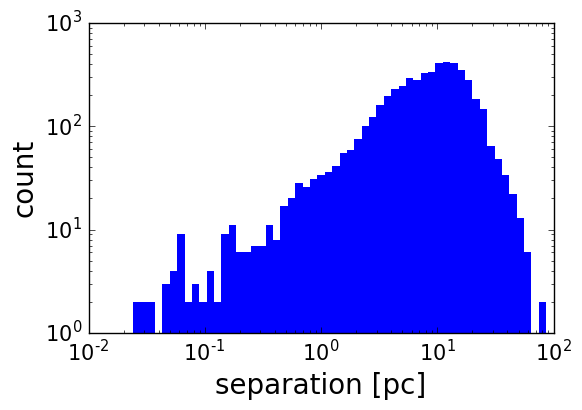

In [25]:
_ = hist(pairidx['sep'][cut], logspace(-2,2,64), log=True,)
xscale('log')
xlabel('separation [pc]')
ylabel('count')

# Color-Magnitude Diagram

In [26]:
t2mass = fits.getdata('/Users/semyeong/data/gaia/tgas_source/tgas-matched-2mass.fits')

In [81]:
t2mass.dtype.names

('ra',
 'dec',
 'key',
 'err_major',
 'err_minor',
 'err_angle',
 'designation',
 'northern_hemi',
 'galaxy_contam',
 'prox',
 'prox_angle',
 'prox_key',
 'date_year',
 'date_month',
 'date_day',
 'jdate',
 'scan',
 'minor_planet',
 'phi_opt',
 'glon',
 'glat',
 'x_scan',
 'n_opt_matches',
 'dist_opt',
 'b_m_opt',
 'vr_m_opt',
 'dist_edge_ns',
 'dist_edge_ew',
 'dist_flag_ns',
 'dist_flag_ew',
 'dup_src',
 'use_src',
 'association',
 'coadd_key',
 'coadd',
 'scan_key',
 'xsc_key',
 'j_mag',
 'j_cmsig',
 'j_msigcom',
 'j_m_stdap',
 'j_msig_stdap',
 'j_snr',
 'j_quality',
 'j_read',
 'j_blend',
 'j_cc',
 'j_ndet_m',
 'j_ndet_n',
 'j_psfchi',
 'h_mag',
 'h_cmsig',
 'h_msigcom',
 'h_m_stdap',
 'h_msig_stdap',
 'h_snr',
 'h_quality',
 'h_read',
 'h_blend',
 'h_cc',
 'h_ndet_m',
 'h_ndet_n',
 'h_psfchi',
 'k_mag',
 'k_cmsig',
 'k_msigcom',
 'k_m_stdap',
 'k_msig_stdap',
 'k_snr',
 'k_quality',
 'k_read',
 'k_blend',
 'k_cc',
 'k_ndet_m',
 'k_ndet_n',
 'k_psfchi',
 'matched',
 'matchdist')

In [27]:
gjcolor = tgas._data['phot_g_mean_mag']- t2mass['j_mag']
gMag = tgas._data['phot_g_mean_mag'] + 5*(log10(tgas._data['parallax']*1e-3)+1)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [28]:
gjcolor1 = gjcolor[pairidx['star1']]
gMag1 = gMag[pairidx['star1']]
gjcolor2 = gjcolor[pairidx['star2']]
gMag2 = gMag[pairidx['star2']]

gjcolor1_rand = gjcolor[pairidx_rand['star1']]
gjcolor2_rand = gjcolor[pairidx_rand['star2']]
gMag1_rand = gMag[pairidx_rand['star1']]
gMag2_rand = gMag[pairidx_rand['star2']]

both_matched = t2mass['matched'][pairidx['star1']] & t2mass['matched'][pairidx['star2']]

In [41]:
dcmd = hypot(gjcolor1-gjcolor2, gMag1-gMag2)
dcmd_rand = hypot(gjcolor1_rand-gjcolor2_rand, gMag1_rand-gMag2_rand)

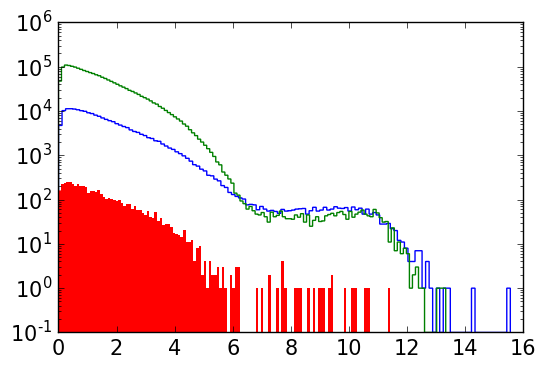

In [43]:
_ = hist(dcmd_rand, 128 ,log=True, histtype='step')
_ = hist(dcmd[llr<3], 128 ,log=True, histtype='step')
_ = hist(dcmd[cut], 128 ,log=True)

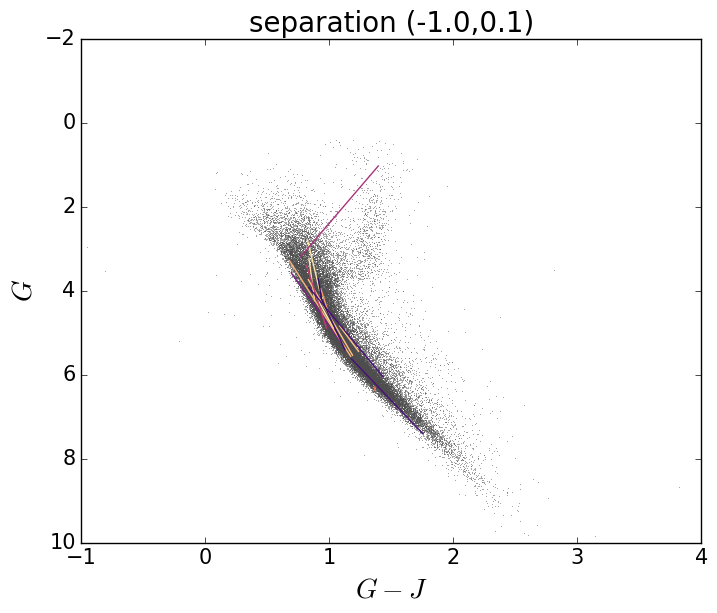

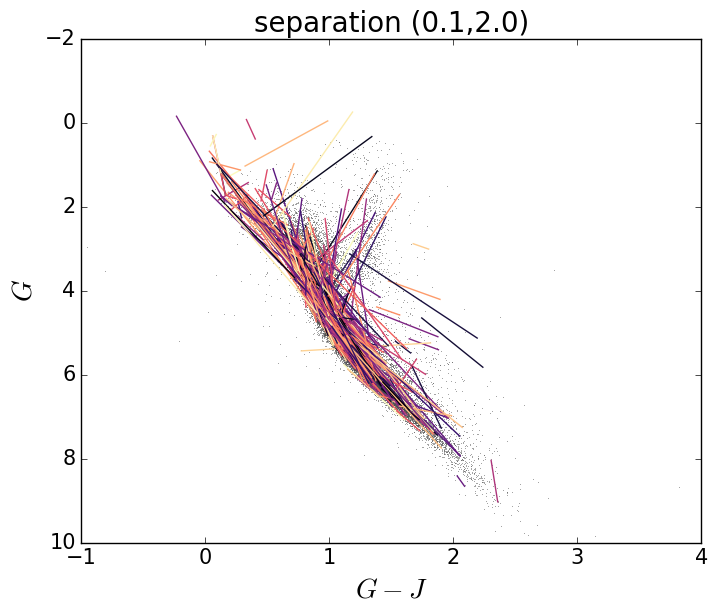

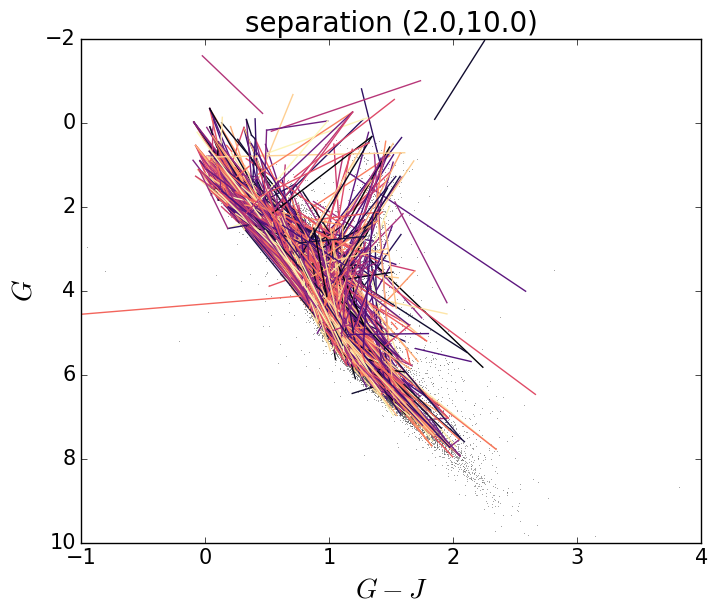

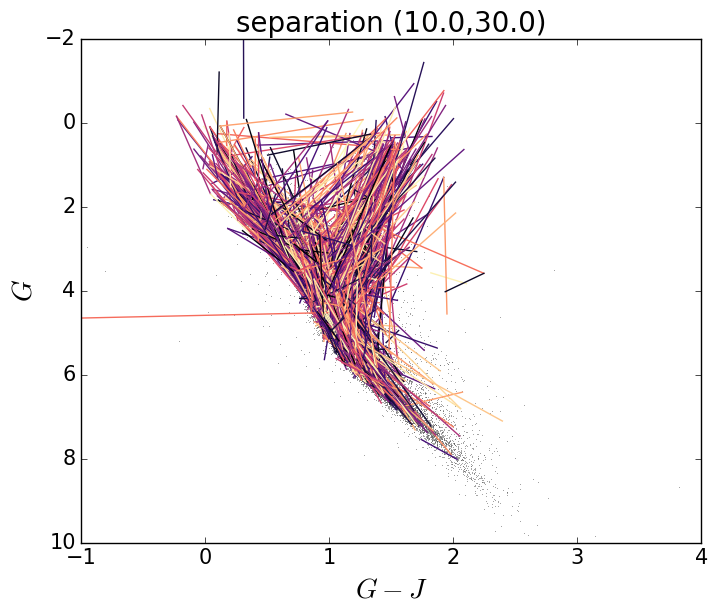

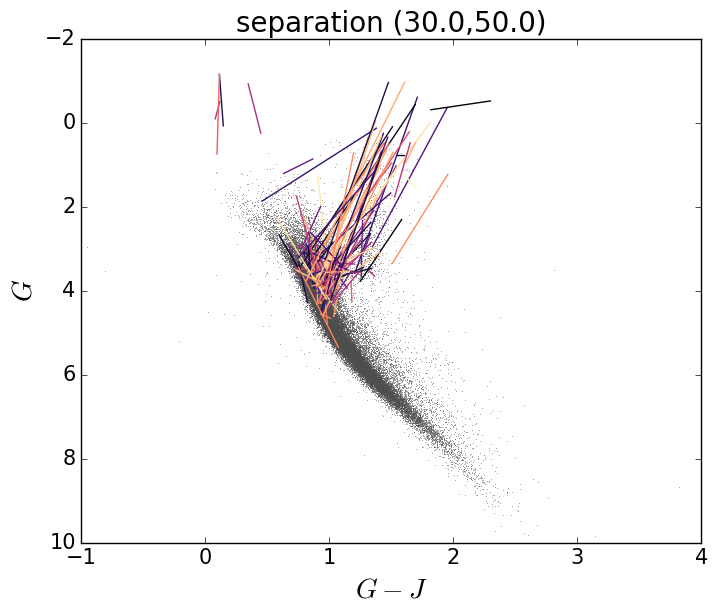

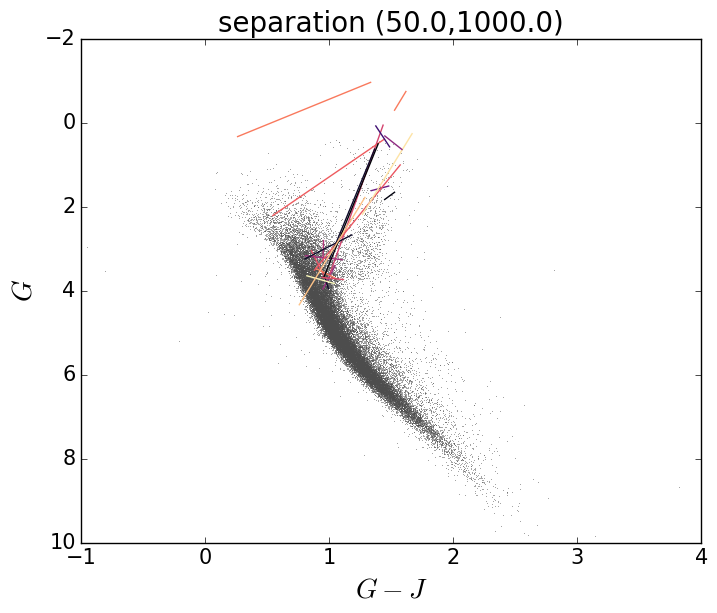

In [29]:
sncut = tgas.parallax_snr>32

for seplow, sephigh in [(-1,0.1), (0.1, 2), (2, 10), (10,30), (30,50), (50,1e3)]:
    fig, ax = subplots(1, 1, figsize=(8,6.5))
    plot(gjcolor[sncut], gMag[sncut], ',',  c='0.3', alpha=.5)
    cond = cut & both_matched & (sep.value>seplow) & (sep.value<sephigh)
    # cond = (fabs(llr-0)<.01) & (sep.value>30)
    for pairx, pairy in zip(vstack([gjcolor1[cond], gjcolor2[cond]]).T,
                            vstack([gMag1[cond], gMag2[cond]]).T):
        plot(pairx, pairy, color=cm.magma(random.uniform()), )
    title('separation (%.1f,%.1f)' % (seplow, sephigh), size=20)

    xlim(-1,4)
    ylim(10,-2)
    xlabel('$G-J$')
    ylabel('$G$')

In [30]:
gMags = vstack([gMag1, gMag2]).T
gjcolors = vstack([gjcolor1, gjcolor2]).T

In [ ]:
sncut = tgas.parallax_snr>32

fig, ax = subplots(1, 1, figsize=(8,6.5))
plot(gjcolor[sncut], gMag[sncut], ',',  c='gray', alpha=.5)

cond = cut & (sep.value>30)
# cond = (fabs(llr-0)<.01) & (sep.value>30)

isort = argmin(vstack([gMag1[cond], gMag2[cond]]), axis=0)

In [ ]:
for pairx, pairy in zip(vstack([gjcolor1[cond], gjcolor2[cond]]).T,
                        vstack([gMag1[cond], gMag2[cond]]).T):
    plot(pairx, pairy, color=cm.magma(random.uniform()), )

xlim(-1,4)
ylim(10,-2)
xlabel('$G-J$')
ylabel('$G$')

In [ ]:
bg = t2mass['matched'] & sncut
close_in_pm = (dpm_kms_gxyz<1) & t2mass[sncut]['matched']
print close_in_pm.sum()

fig, ax = subplots(1, 1, figsize=(10,6.5))

# sca(ax[0])
# hexbin(gjcolor[bg], gMag[bg], norm=mpl.colors.LogNorm(), cmap='gray_r')
# plot(gjcolor[close_in_pm], gMag[close_in_pm], 'r.')
scatter(gjcolor[close_in_pm], gMag[close_in_pm], c=sep_pc_gxyz[close_in_pm], norm=mpl.colors.LogNorm(), cmap='magma')
xlim(-1,4)
ylim(10,-2)
xlabel('G-J')
ylabel('G')
colorbar(label='physical separation [pc]')
title(r'$\Delta v_\perp<1$ km/s, $S/N_\varpi>10$, matched w/ 2MASS')

In [99]:
i, j = pair_idx[weird][0]
print(i, j)
Vinvs = [np.eye(3)/15.**2,
             np.eye(3)/30.**2,
             np.eye(3)/50.**2]   # 3x3 inverse variances for gaussian prior on velocities
prior_weights = np.array([0.3, 0.55, 0.15])
gwb.fml.ln_H1_FML(tgas[i], tgas[j], Vinvs, prior_weights=prior_weights, n_dist_samples=1024), \
gwb.fml.ln_H2_FML(tgas[i], tgas[j], Vinvs, prior_weights=prior_weights, n_dist_samples=1024)

58027 59125


(-17.414319033011054, -11.174047302306779)

# Velocity prior

In [5]:
print((tgas.parallax_snr>32).sum())

42385


In [6]:
tgassn = tgas[tgas.parallax_snr>32]

In [7]:
vtan = tgassn.get_vtan()

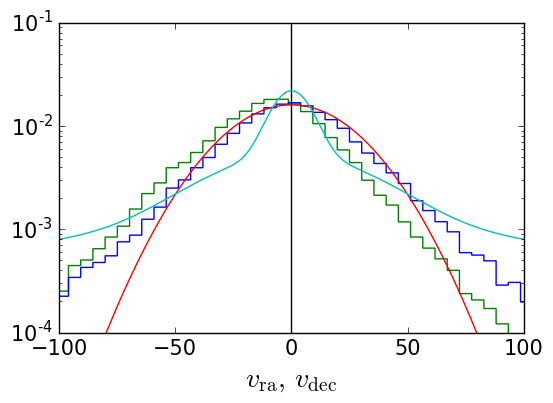

In [8]:
_ = hist(vtan.value, 150, histtype='step', normed=True)
xlim(-100,100)
axvline(0, c='k', lw=1)
vtmp = linspace(-200,200,1000)
def gaussian(sigma):
    def f(x):
        return 1./(sqrt(2*pi)*sigma)*exp(-x**2/(2.*sigma**2))
    return f
plot(vtmp, gaussian(25.)(vtmp), label='old prior')
plot(vtmp, (gaussian(8.)(vtmp)/3.+gaussian(32.)(vtmp)/3.+gaussian(128)(vtmp)/3.),
     label='new prior')
yscale('log')
ylim(1e-4)
xlabel(r'$v_\mathrm{ra},\,v_\mathrm{dec}$')


In [42]:
from scipy import optimize

In [55]:
f(1,0.5*(bins[1:]+bins[:-1]), v)

-3.7041150751293559

In [69]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [75]:
v, bins = histogram(vtan.value, 150, normed=True)
def ngauss(p):
    def ff(x):
        out = 0.
        for gp in chunker(p, 2):
            sigma1, a1 = gp
            g1 = gaussian(sigma1)(x)*a1
            out = out + g1
        return out
    return ff
def f(p, x, y):
    model = ngauss(p)(x)
    return log(sum((model-y)**2))
g1 = optimize.minimize(f, [10, .5,], args=(0.5*(bins[1:]+bins[:-1]), v))
g2 = optimize.minimize(f, [10, .5, 50, .1], args=(0.5*(bins[1:]+bins[:-1]), v))
g3 = optimize.minimize(f, [10, .5, 50, .1, 100., .1], args=(0.5*(bins[1:]+bins[:-1]), v))

In [76]:
g2

      fun: -10.126443727378657
 hess_inv: array([[  2.12467050e+02,   1.35235627e+01,   3.77716588e+02,
         -1.28901278e+01],
       [  1.35235627e+01,   9.44205883e-01,   2.80960415e+01,
         -8.92330784e-01],
       [  3.77716588e+02,   2.80960415e+01,   9.56035689e+02,
         -2.56815827e+01],
       [ -1.28901278e+01,  -8.92330784e-01,  -2.56815827e+01,
          8.62822264e-01]])
      jac: array([  0.00000000e+00,   1.43051147e-06,  -1.19209290e-07,
         2.74181366e-06])
  message: 'Optimization terminated successfully.'
     nfev: 252
      nit: 38
     njev: 42
   status: 0
  success: True
        x: array([ 16.18178167,   0.40000612,  34.61279745,   0.59178856])

In [77]:
g3

      fun: -10.130373199926542
 hess_inv: array([[  9.78512580e+02,   7.27902328e+01,   3.72350469e+03,
          6.36286491e+01,   1.04130943e+04,  -1.34841371e+02],
       [  7.27902328e+01,   5.65626034e+00,   3.01826755e+02,
          5.57031037e+00,   8.58375109e+02,  -1.11024159e+01],
       [  3.72350469e+03,   3.01826755e+02,   1.74780729e+04,
          3.82083184e+02,   5.35824832e+04,  -6.76286331e+02],
       [  6.36286491e+01,   5.57031037e+00,   3.82083184e+02,
          1.12472874e+01,   1.41143397e+03,  -1.66103521e+01],
       [  1.04130943e+04,   8.58375109e+02,   5.35824832e+04,
          1.41143397e+03,   1.91675812e+05,  -2.23546150e+03],
       [ -1.34841371e+02,  -1.11024159e+01,  -6.76286331e+02,
         -1.66103521e+01,  -2.23546150e+03,   2.74168069e+01]])
      jac: array([ -1.19209290e-07,  -3.93390656e-06,   1.19209290e-07,
        -7.86781311e-06,   0.00000000e+00,  -2.38418579e-06])
  message: 'Optimization terminated successfully.'
     nfev: 776
      n

In [92]:
diag?

(-200, 200)

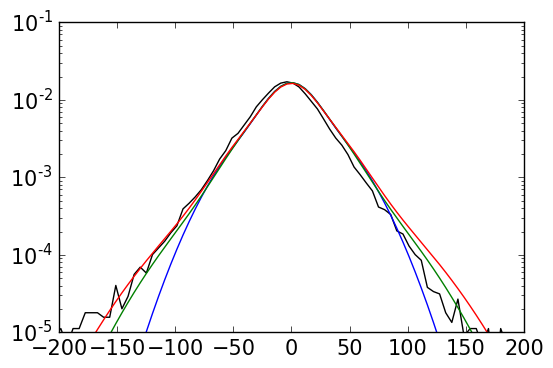

In [87]:
x = 0.5*(bins[1:]+bins[:-1])
plot(x, v, 'k-')
plot(x, ngauss(g2['x'])(x))
plot(x, ngauss(g3['x'])(x))
plot(x, ngauss([15.,.3,30.,.55,55,.15])(x))
yscale('log')
ylim(1e-5)
xlim(-200,200)